# ⚛️ H₃⁺ Noisy VQE — Singles vs Doubles vs UCCSD

This notebook runs **noisy VQE** for the trihydrogen cation **H₃⁺**
using three excitation classes:

- **UCC Singles**  
- **UCC Doubles**  
- **UCC Singles + Doubles (UCCSD)**  

We use a fixed noise model:

- **Depolarizing noise:** 2% per qubit  
- **Amplitude damping:** 4% per qubit  

and a fixed optimisation setup:

- Ansätze: built with `excitation_ansatz` (UCC-style)  
- Optimizer: **Adam**  
- Device: `default.mixed` (density-matrix simulator)  

---

## 🎯 Outputs

For each excitation type we compute:

- **Convergence curve**: energy vs iteration  
- **Final noisy density matrix** (via `qml.state()` on `default.mixed`)  
- **Approximate “ket-form” representation** using diagonal populations  

This notebook complements:

- `H3plus/Noiseless.ipynb` (noiseless reference)  
- `H3plus/Noise_Scan.ipynb` (full noise sweeps & statistics)  

by focusing on a **single fixed noise level** across different excitation manifolds.


In [1]:
# Core scientific stack
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
from pennylane.qchem import excitations
import matplotlib.pyplot as plt

import sys, os, json, time
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from vqe.vqe_utils import (
    IMG_DIR,
    excitation_ansatz,
    get_optimizer,
    set_seed,
    ensure_dirs,
    make_run_config_dict,
    run_signature,
    find_existing_run,
    save_run_record,
    build_run_filename,
)

ensure_dirs()

# 🔧 Part 1 — H₃⁺ Molecular Setup (Noisy Device)

Geometry: equilateral H₃⁺ (Å)  
Basis: STO-3G  
Charge: +1  
Electrons: 2  

We also build:

- Molecular Hamiltonian \(H\)  
- Hartree–Fock reference bitstring  
- Singles + doubles excitation lists  

In [2]:
seed = 0
set_seed(seed)

symbols = ["H", "H", "H"]
coordinates = np.array([
    [0.000000,  1.000000,  0.000000],
    [-0.866025, -0.500000, 0.000000],
    [ 0.866025, -0.500000, 0.000000],
])
basis = "STO-3G"
electrons = 2

hamiltonian, qubits = qchem.molecular_hamiltonian(
    symbols, coordinates, charge=+1, basis=basis
)
hf = qchem.hf_state(electrons, qubits)

num_wires = qubits
print(f"H₃⁺ → {num_wires} qubits")
print("Hartree–Fock state:", "|" + "".join(str(int(b)) for b in hf) + "⟩")

# Noisy device
dev = qml.device("default.mixed", wires=num_wires)

# Excitations
singles, doubles = excitations(electrons, qubits)
singles = [tuple(x) for x in singles]
doubles = [tuple(x) for x in doubles]

print(f"Singles: {len(singles)}   Doubles: {len(doubles)}")

H₃⁺ → 6 qubits
Hartree–Fock state: |110000⟩
Singles: 4   Doubles: 4


# 🧪 Part 2 — Noise Model

We use a simple, fixed NISQ-style noise model:

- **DepolarizingChannel(0.02)** on each qubit  
- **AmplitudeDamping(0.04)** on each qubit  

Both channels are applied **after** the UCC ansatz.

In [3]:
depolarizing_prob = 0.02
amplitude_damping_prob = 0.04

# 🧩 Part 3 — Noisy Cost Function Factory

We build a QNode generator:

- `excitation_type="single"` → UCC Singles  
- `excitation_type="double"` → UCC Doubles  
- `excitation_type="both"` → UCC Singles + Doubles (UCCSD)  

Each QNode:

1. Prepares the HF state internally via `excitation_ansatz`  
2. Applies the selected excitation manifold  
3. Applies depolarizing + amplitude-damping channels  
4. Returns `⟨H⟩` on `default.mixed`

In [4]:
def get_cost_function(excitation_type):
    """Return a noisy VQE cost function for the chosen excitation class."""
    @qml.qnode(dev, diff_method="finite-diff")
    def cost_fn(params):
        # Select which excitations to apply
        if excitation_type == "single":
            selected = (singles, [])
        elif excitation_type == "double":
            selected = ([], doubles)
        else:  # "both"
            selected = (singles, doubles)

        excitation_ansatz(
            params,
            wires=range(num_wires),
            hf_state=hf,
            excitations=selected,
            excitation_type=excitation_type,
        )

        # Noise channels on each qubit
        for w in range(num_wires):
            qml.DepolarizingChannel(depolarizing_prob, wires=w)
            qml.AmplitudeDamping(amplitude_damping_prob, wires=w)

        return qml.expval(hamiltonian)

    return cost_fn

# 💾 Part 4 — Cache-Aware Noisy VQE Runner

`run_vqe_with_cache_for_excitation(...)`:

- Builds a config dictionary (including noise parameters)  
- Computes a unique signature and checks for an existing JSON run  
- If present:
  - loads energies + final parameters  
- Otherwise:
  - runs Adam optimisation  
  - saves a JSON record with:
    - energies  
    - final parameters  
    - metadata  

This function is called separately for:

- `"single"`  
- `"double"`  
- `"both"`  

In [5]:
def run_vqe_with_cache_for_excitation(excitation_type, stepsize, max_iterations):
    """Run or load a noisy VQE for a given excitation class."""
    # Ansatz description and parameter count
    if excitation_type == "single":
        ansatz_desc = "UCC singles"
        n_params = len(singles)
    elif excitation_type == "double":
        ansatz_desc = "UCC doubles"
        n_params = len(doubles)
    else:
        ansatz_desc = "UCC singles+doubles"
        n_params = len(singles) + len(doubles)

    cost_fn = get_cost_function(excitation_type)

    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc=ansatz_desc,
        optimizer_name="Adam",
        stepsize=stepsize,
        max_iterations=max_iterations,
        seed=seed,
        noisy=True,
        depolarizing_prob=depolarizing_prob,
        amplitude_damping_prob=amplitude_damping_prob,
    )
    cfg["excitation_type"] = excitation_type

    sig = run_signature(cfg)
    fname = build_run_filename(f"H3plus_Noisy_{excitation_type}", "Adam", seed, sig)
    existing = find_existing_run(sig)

    # --- Load cached run ---
    if existing:
        with open(existing) as f:
            rec = json.load(f)
        print(f"[reuse] {excitation_type}: loaded {existing}")

        energy = rec["energies"]
        params = np.array(rec["final_params"], requires_grad=True)
        return {"energy": energy, "params": params}

    # --- Fresh run ---
    opt = get_optimizer("Adam", stepsize=stepsize)
    params = np.zeros(n_params, requires_grad=True)

    energies = [float(cost_fn(params))]
    for _ in range(max_iterations):
        params, e_prev = opt.step_and_cost(cost_fn, params)
        energies.append(float(e_prev))
    energies[-1] = float(cost_fn(params))

    run_record = {
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "molecule": "H3plus",
        "symbols": symbols,
        "geometry": coordinates.tolist(),
        "basis": basis,
        "electrons": electrons,
        "num_wires": num_wires,
        "excitation_type": excitation_type,
        "ansatz": ansatz_desc,
        "optimizer": {
            "name": "Adam",
            "stepsize": stepsize,
            "iterations_planned": max_iterations,
            "iterations_ran": len(energies) - 1,
        },
        "seed": seed,
        "energies": energies,
        "final_params": [float(x) for x in params],
        "config_hash": sig,
        "noisy": True,
        "depolarizing_prob": depolarizing_prob,
        "amplitude_damping_prob": amplitude_damping_prob,
    }

    save_run_record(fname, run_record)
    print(f"[saved] {fname}")

    return {"energy": energies, "params": params}

# 🚀 Part 5 — Run Noisy VQE for Singles, Doubles, UCCSD

In [6]:
excitation_types = ["single", "double", "both"]
results = {}

for exc_type in excitation_types:
    print(f"\nRunning noisy VQE with {exc_type} excitations...")
    results[exc_type] = run_vqe_with_cache_for_excitation(
        excitation_type=exc_type,
        stepsize=0.2,
        max_iterations=50,
    )


Running noisy VQE with single excitations...
[reuse] single: loaded /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H3plus_Noisy_single_Adam_s0__7f670bdf291b.json

Running noisy VQE with double excitations...
[reuse] double: loaded /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H3plus_Noisy_double_Adam_s0__f8eccb84958e.json

Running noisy VQE with both excitations...
[reuse] both: loaded /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H3plus_Noisy_both_Adam_s0__a73165dba932.json


# 📉 Part 6 — Convergence Comparison

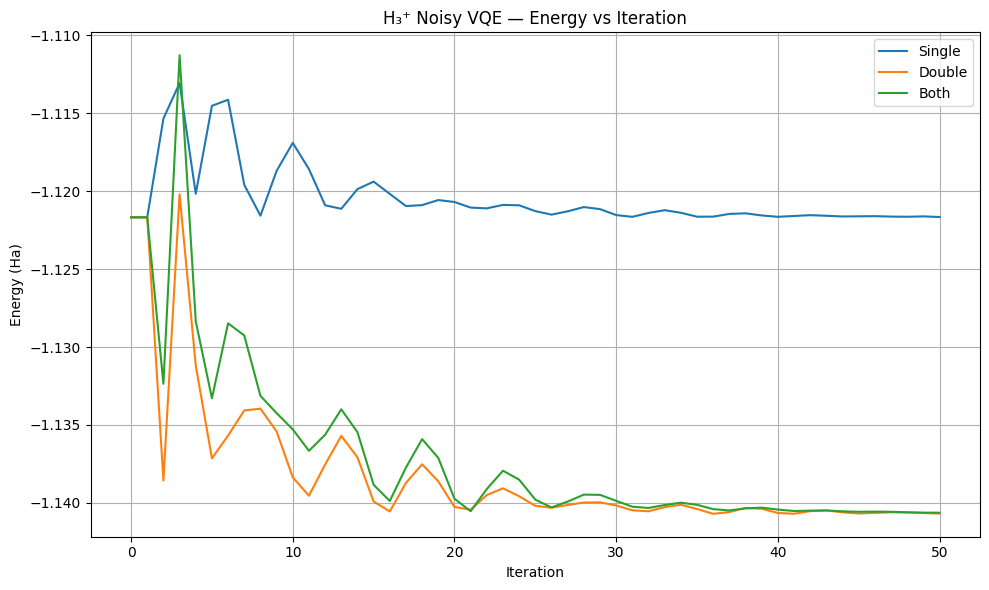

In [7]:
plt.figure(figsize=(10, 6))

for exc_type in excitation_types:
    plt.plot(results[exc_type]["energy"], label=f"{exc_type.capitalize()}")

plt.title("H₃⁺ Noisy VQE — Energy vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(f"{IMG_DIR}/H3plus_Noisy_Excitation_Comparison.png", dpi=300)
plt.show()

# 🔬 Part 7 — Noisy Density Matrices & Approximate “Ket” View

On `default.mixed`, `qml.state()` returns the **density matrix** ρ.

We:

- Rebuild a QNode that returns the **full state** (ρ) under noise  
- Extract its diagonal (computational basis populations)  
- Build a compact “ket-like” expansion using diagonal entries:

\[
\rho \approx \sum_i p_i |i\rangle\langle i| \quad\Rightarrow\quad
|\psi\rangle \approx \sum_i \sqrt{p_i}\,|i\rangle
\]

Here, for simplicity, we directly write:

\[
|\psi\rangle \approx \sum_i p_i |i\rangle
\]

with a small threshold on \( p_i \).

In [8]:
def get_noisy_state_qnode(excitation_type, selected_ex):
    """Return a QNode that outputs the noisy density matrix for a given excitation class."""
    @qml.qnode(dev, diff_method="finite-diff")
    def circuit(params):
        excitation_ansatz(
            params,
            wires=range(num_wires),
            hf_state=hf,
            excitations=selected_ex,
            excitation_type=excitation_type,
        )
        for w in range(num_wires):
            qml.DepolarizingChannel(depolarizing_prob, wires=w)
            qml.AmplitudeDamping(amplitude_damping_prob, wires=w)
        return qml.state()
    return circuit

In [9]:
for exc_type in excitation_types:
    final_E = results[exc_type]["energy"][-1]
    final_params = results[exc_type]["params"]

    print("-" * 80)
    print(f"Final energy ({exc_type}): {final_E:.8f} Ha")

    # Select excitations
    if exc_type == "single":
        selected = (singles, [])
    elif exc_type == "double":
        selected = ([], doubles)
    else:
        selected = (singles, doubles)

    qnode = get_noisy_state_qnode(exc_type, selected)
    rho = qnode(final_params)  # density matrix (default.mixed)

    diag = np.diag(rho)

    # Approximate ket notation from diagonal populations
    threshold = 1e-2
    ket_terms = [
        f"({amp:.4f}|{i:0{num_wires}b}⟩)"
        for i, amp in enumerate(diag)
        if abs(amp) > threshold
    ]
    ket_notation = " + ".join(ket_terms)

    print("Approximate noisy state (from diagonal of ρ):")
    print(f"|ψ⟩ ≈ {ket_notation}")

--------------------------------------------------------------------------------
Final energy (single): -1.12165384 Ha
Approximate noisy state (from diagonal of ρ):
|ψ⟩ ≈ (0.0475+0.0000j|010000⟩) + (0.0475+0.0000j|100000⟩) + (0.8521+0.0000j|110000⟩) + (0.0110+0.0000j|110001⟩) + (0.0110+0.0000j|110010⟩) + (0.0110+0.0000j|110100⟩) + (0.0110+0.0000j|111000⟩)
--------------------------------------------------------------------------------
Final energy (double): -1.14068446 Ha
Approximate noisy state (from diagonal of ρ):
|ψ⟩ ≈ (0.0468+0.0000j|010000⟩) + (0.0468+0.0000j|100000⟩) + (0.8403+0.0000j|110000⟩) + (0.0109+0.0000j|110001⟩) + (0.0109+0.0000j|110010⟩) + (0.0109+0.0000j|110100⟩) + (0.0109+0.0000j|111000⟩)
--------------------------------------------------------------------------------
Final energy (both): -1.14063697 Ha
Approximate noisy state (from diagonal of ρ):
|ψ⟩ ≈ (0.0468+0.0000j|010000⟩) + (0.0468+0.0000j|100000⟩) + (0.8403+0.0000j|110000⟩) + (0.0109+0.0000j|110001⟩) + (0.0109